### Simple CNN, flower classifies from (tensorflow dataset) using pytorch 

In [13]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import torch
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [15]:
import pathlib
ds_path = pathlib.Path(data_dir)


image_path = {
    "daisy"         : list(ds_path.glob('daisy/*.jpg')),
    "dandelion"     : list(ds_path.glob('dandelion/*.jpg')),
    "roses"         : list(ds_path.glob('roses/*.jpg')),
    "sunflowers"    : list(ds_path.glob('sunflowers/*.jpg')),  
    "tulips"        : list(ds_path.glob('tulips/*.jpg'))  
}

image_label = {
    "daisy"         : 0,
    "dandelion"     : 1,
    "roses"         : 2,
    "sunflowers"    : 3,
    "tulips"        : 4,

#Lets make a reverse key as well, can be used for reverse lookup
# Also we can use {key = [key for key, value in dict_obj.items() if value == 'value'][0]} incase needed

    0               : "daisy",
    1               : "dandelion",
    2               : "roses",
    3               : "sunflowers",
    4               : "tulips"
}

image_label_list = []
for label, path_list in image_path.items():
    for path in path_list:
        image_label_list.append([path, image_label[label]])

# Create Train and Test Datasets using Random split:
from torch.utils.data import random_split
train_set, test_set = random_split(image_label_list, [0.8, 0.2])
print("Train: ", len(train_set), "Test: ", len(test_set))

Train:  2936 Test:  734


In [16]:
from torch.utils.data import Dataset
import cv2
import numpy as np

class image_dataset(Dataset):
    def __init__(self, image_list, std=False):
        super(image_dataset, self).__init__()
        self.image_list = image_list
        self.std = std
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        image_path, label = self.image_list[idx]
        image = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.resize(image, (180, 180))                             # Resize all images to uniform size 180x180 with 3 channels

        if self.std:
            image = image / 255.0
        
        if image.shape[0] != 3:
            image = image.reshape(3, image.shape[0], image.shape[1])      # Reshape the image to 3x180x180      

        label = torch.tensor(label)
        image = torch.tensor(image)
    
        return image, label

In [17]:
from torch.utils.data import DataLoader
train_dataset = image_dataset(train_set, std=True)
test_dataset  = image_dataset(test_set,  std=True)

train_loader  = DataLoader(train_dataset, batch_size=250, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=50, shuffle=True) # Not neeed to shuffle the test data

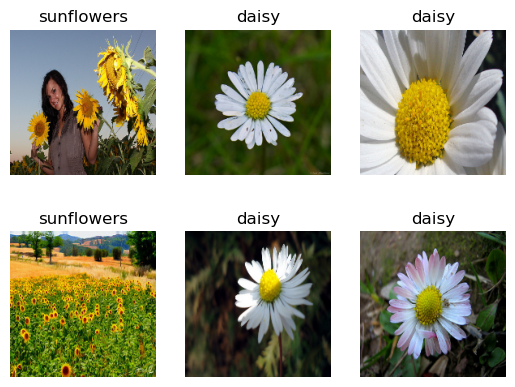

In [18]:
# Lets plot some sample for Train Dataset using train loader
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

# Lets print 6 images
images = images.reshape(-1, images.shape[2], images.shape[3], images.shape[1]) # reshape the image from (B x C x H x W) to (B x H x W x C) for matplotlib to plot
images = images * 255 # if std is on then change it back
images = images.numpy().astype(np.int64) # Convert it from float to Integer for display
labels = labels.numpy()
for i in range (6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(image_label[labels[i]])
    plt.axis('off')
plt.show()

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.drop1 = nn.Dropout2d(0.5)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.drop2 = nn.Dropout2d(0.5)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.drop3 = nn.Dropout2d(0.5)

        self.flat  = nn.Flatten()
        self.drop  = nn.Dropout2d(.5)

        self.fully= nn.Linear(64*6*6, out_features=num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.drop3(x)
      
        x = self.flat(x)
        x = self.drop(x)
        x = self.fully(x)
        
        return x

In [20]:
from torchsummary import summary
x = (3, 180, 180)
model_summary = CNN(in_channels=3, num_classes=5)
summary(model_summary, x)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 60, 60]             448
         MaxPool2d-2           [-1, 16, 59, 59]               0
         Dropout2d-3           [-1, 16, 59, 59]               0
            Conv2d-4           [-1, 32, 20, 20]           4,640
         MaxPool2d-5           [-1, 32, 19, 19]               0
         Dropout2d-6           [-1, 32, 19, 19]               0
            Conv2d-7             [-1, 64, 7, 7]          18,496
         MaxPool2d-8             [-1, 64, 6, 6]               0
         Dropout2d-9             [-1, 64, 6, 6]               0
          Flatten-10                 [-1, 2304]               0
        Dropout2d-11                 [-1, 2304]               0
           Linear-12                    [-1, 5]          11,525
Total params: 35,109
Trainable params: 35,109
Non-trainable params: 0
---------------------------------

In [21]:
IN_CHANNELS = 3
LEARING_RATE = 0.001
NUM_OF_CLASSES = 5
NUM_OF_EPOCHS = 50

In [22]:
# Initialize the model...
import torch.optim as optim
from tqdm import tqdm
model = CNN(in_channels=IN_CHANNELS, num_classes=NUM_OF_CLASSES).to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARING_RATE)

In [23]:
def model_train(NUM_OF_EPOCHS):
    for epoch in range (1, NUM_OF_EPOCHS+1):
        corr_pred = 0
        total_sample = 0

        for image, label in tqdm(train_loader):
            image = image.to(device=device)
            label = label.to(device=device)

            output = model(image)

            _, pred_index = output.max(1)
            corr_pred += pred_index.eq(label).sum() 
            total_sample += len(label)

            loss = criterion(output, label)
            
            model.zero_grad()    
            loss.backward()
            optimizer.step()

        print(f'epoch:{epoch}/{NUM_OF_EPOCHS}, train loss: {loss.item():.4f}, train accuracy: {corr_pred/total_sample:.4f}, corr_pred:{corr_pred}, tot_samp:{total_sample}')

In [24]:
model_train(NUM_OF_EPOCHS)

100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


epoch:1/50, train loss: 1.6137, train accuracy: 0.2262, corr_pred:664, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


epoch:2/50, train loss: 1.6256, train accuracy: 0.2428, corr_pred:713, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


epoch:3/50, train loss: 1.5872, train accuracy: 0.2575, corr_pred:756, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


epoch:4/50, train loss: 1.5781, train accuracy: 0.2599, corr_pred:763, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


epoch:5/50, train loss: 1.5674, train accuracy: 0.2847, corr_pred:836, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.81it/s]


epoch:6/50, train loss: 1.5311, train accuracy: 0.2899, corr_pred:851, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.79it/s]


epoch:7/50, train loss: 1.5596, train accuracy: 0.3222, corr_pred:946, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


epoch:8/50, train loss: 1.5163, train accuracy: 0.3341, corr_pred:981, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.78it/s]


epoch:9/50, train loss: 1.5301, train accuracy: 0.3256, corr_pred:956, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


epoch:10/50, train loss: 1.4828, train accuracy: 0.3508, corr_pred:1030, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


epoch:11/50, train loss: 1.4592, train accuracy: 0.3566, corr_pred:1047, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


epoch:12/50, train loss: 1.4608, train accuracy: 0.3784, corr_pred:1111, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


epoch:13/50, train loss: 1.3942, train accuracy: 0.3733, corr_pred:1096, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


epoch:14/50, train loss: 1.4523, train accuracy: 0.3866, corr_pred:1135, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


epoch:15/50, train loss: 1.3543, train accuracy: 0.3774, corr_pred:1108, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


epoch:16/50, train loss: 1.4382, train accuracy: 0.4019, corr_pred:1180, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


epoch:17/50, train loss: 1.4100, train accuracy: 0.4063, corr_pred:1193, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


epoch:18/50, train loss: 1.4372, train accuracy: 0.3941, corr_pred:1157, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


epoch:19/50, train loss: 1.3038, train accuracy: 0.4183, corr_pred:1228, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


epoch:20/50, train loss: 1.3213, train accuracy: 0.4097, corr_pred:1203, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


epoch:21/50, train loss: 1.3119, train accuracy: 0.4336, corr_pred:1273, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


epoch:22/50, train loss: 1.3704, train accuracy: 0.4213, corr_pred:1237, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


epoch:23/50, train loss: 1.2893, train accuracy: 0.4292, corr_pred:1260, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.73it/s]


epoch:24/50, train loss: 1.3235, train accuracy: 0.4428, corr_pred:1300, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


epoch:25/50, train loss: 1.2726, train accuracy: 0.4363, corr_pred:1281, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


epoch:26/50, train loss: 1.2690, train accuracy: 0.4363, corr_pred:1281, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


epoch:27/50, train loss: 1.3063, train accuracy: 0.4435, corr_pred:1302, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.74it/s]


epoch:28/50, train loss: 1.2654, train accuracy: 0.4424, corr_pred:1299, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


epoch:29/50, train loss: 1.2972, train accuracy: 0.4533, corr_pred:1331, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


epoch:30/50, train loss: 1.3757, train accuracy: 0.4401, corr_pred:1292, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.75it/s]


epoch:31/50, train loss: 1.1832, train accuracy: 0.4489, corr_pred:1318, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


epoch:32/50, train loss: 1.2664, train accuracy: 0.4588, corr_pred:1347, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.71it/s]


epoch:33/50, train loss: 1.2146, train accuracy: 0.4516, corr_pred:1326, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.69it/s]


epoch:34/50, train loss: 1.3215, train accuracy: 0.4591, corr_pred:1348, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


epoch:35/50, train loss: 1.2672, train accuracy: 0.4523, corr_pred:1328, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


epoch:36/50, train loss: 1.3621, train accuracy: 0.4421, corr_pred:1298, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


epoch:37/50, train loss: 1.3238, train accuracy: 0.4598, corr_pred:1350, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


epoch:38/50, train loss: 1.2058, train accuracy: 0.4574, corr_pred:1343, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.67it/s]


epoch:39/50, train loss: 1.2365, train accuracy: 0.4612, corr_pred:1354, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.53it/s]


epoch:40/50, train loss: 1.2741, train accuracy: 0.4860, corr_pred:1427, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


epoch:41/50, train loss: 1.3787, train accuracy: 0.4704, corr_pred:1381, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


epoch:42/50, train loss: 1.2171, train accuracy: 0.4676, corr_pred:1373, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.58it/s]


epoch:43/50, train loss: 1.1978, train accuracy: 0.4792, corr_pred:1407, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.62it/s]


epoch:44/50, train loss: 1.2509, train accuracy: 0.4762, corr_pred:1398, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


epoch:45/50, train loss: 1.2389, train accuracy: 0.4864, corr_pred:1428, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.63it/s]


epoch:46/50, train loss: 1.1596, train accuracy: 0.4877, corr_pred:1432, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.61it/s]


epoch:47/50, train loss: 1.2563, train accuracy: 0.4867, corr_pred:1429, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.64it/s]


epoch:48/50, train loss: 1.2004, train accuracy: 0.4888, corr_pred:1435, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.65it/s]


epoch:49/50, train loss: 1.2338, train accuracy: 0.4826, corr_pred:1417, tot_samp:2936


100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

epoch:50/50, train loss: 1.2457, train accuracy: 0.4871, corr_pred:1430, tot_samp:2936


In [25]:
# Model Accuracy:
def model_accuracy(loader):
    model.eval()

    corr_pred = 0
    total_sample = 0

    with torch.no_grad():

        for image, label in loader:
            image = image.to(device=device)
            label = label.to(device=device)

            output = model(image)
            _, pred_index = output.max(1)
            corr_pred += pred_index.eq(label).sum()
            total_sample += len(label)

    print("Accuracy:", corr_pred.item()/total_sample)

In [28]:
model_accuracy(test_loader)

Accuracy: 0.5408719346049047


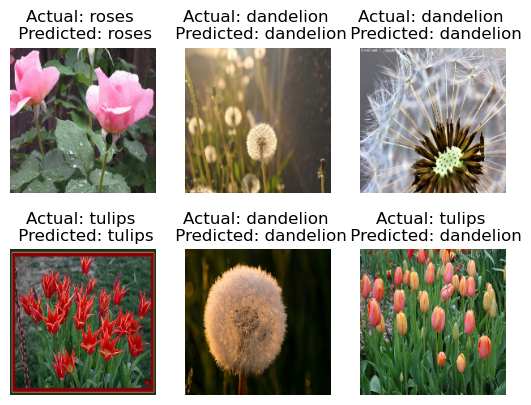

In [34]:
# Lets plot some Predictions from Test Dataset
import matplotlib.pyplot as plt

model.eval()
images, labels = next(iter(test_loader))
images = images.to(device=device)
output = model(images)
_, pred_index = output.max(1)

# Lets print 6 images
images = images.reshape(-1, images.shape[2], images.shape[3], images.shape[1]) # reshape the image from (B x C x H x W) to (B x H x W x C) for matplotlib to plot
images = images * 255 # if std is on then change it back

images = images.to('cpu').numpy().astype(np.int64) # Convert it from float to Integer for display
pred_index = pred_index.to('cpu').numpy()
labels = labels.numpy()

for i in range (6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(f"Actual: {image_label[labels[i]]} \n Predicted: {image_label[pred_index[i]]}")
    plt.axis('off')
plt.show()